In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
import h5py
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [8]:
f = h5py.File("../model/AllParametersLongRUNExMC_MNIST_Nh500_lr0.01_l20.0_NGibbs10000.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'paramW'+str(t) in f:
        alltimes.append(t)

OSError: Unable to open file (unable to open file: name = '../model/AllParametersLongRUNExMC_MNIST_Nh500_lr0.01_l20.0_NGibbs10000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

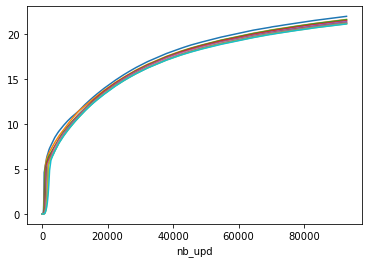

In [7]:
S = torch.zeros(10, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['paramW'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    #plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:10]
#plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)
plt.plot(alltimes,S.T.cpu())
plt.xlabel("nb_upd");

In [5]:
print(alltimes)

[]


In [5]:
t = alltimes[-1]
lr = 0.1
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 10000
it_mean = 50
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V
f.close()

In [6]:
# w_hat : nDim x nb_point
# V : matrice de projection
def TMCSampleND(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    vtab = torch.zeros(v.shape, device=device)
    v_curr = v
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            for j in range(w_next.shape[1]):
                w_next[:,j] += ((2*v_next[i,:]-1)*V[i,j]*norm)
                
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    vtab = vtab*(1/it_mean)
    vtab = vtab.reshape(Nv, nb_point, nb_chain)
    v_curr = v_curr.reshape(Nv, nb_point, nb_chain)
    h_curr = h_curr.reshape(Nh, nb_point, nb_chain)
    return v_curr, h_curr, vtab

In [7]:
_, s, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_data =torch.mm(data, V_g).cpu()/Nv**.5


In [8]:
print(s[:4])

tensor([17.1135, 14.3475,  6.5132,  5.8880], device='cuda:0')


In [9]:
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 50 # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 10000 # Contrainte
#nb_point_x = 125 # Nb de points de discrétisation pour w_hat
#nb_point_y = 125
width_plus = .6
limits = torch.zeros((2, nDim))
for i in range(nDim):
    limits[0, i] = proj_data[:,i].min()-width_plus
    limits[1, i] = proj_data[:,i].max()+width_plus

xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus
nb_point = nb_point_dim.prod()

In [10]:
x_grid = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
x_grid = np.array([x_grid for i in range(nb_point_dim[1])])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(limits[0,1], limits[1,1], nb_point_dim[1])
for i in range(nb_point_dim[1]):
    for j in range(nb_point_dim[0]):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
grid.shape

torch.Size([2, 2500])

In [11]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSampleND(start, w_hat, N, V_g, it_mcmc = it_mcmc, it_mean=it_mean)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [12]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/Nv**.5
proj_data = torch.mm(data, V_g).cpu().numpy()/Nv**.5

In [13]:
newy = torch.mm(torch.mean(vtab, dim = 2).T, V_g)[:,:nDim]/myRBM.Nv**0.5
#y = torch.mm(vtab.T, V_g)[:,:nDim]/myRBM.Nv**0.5
#newy = torch.tensor([torch.mean(y[i*nb_chain:i*nb_chain+nb_chain,:], dim = 0).cpu().numpy() for i in range(nb_point)])
#w_hat = w_hat.cpu().numpy()
#w_hat_b = w_hat_b.cpu().numpy()

In [14]:
grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_dim[0], nb_point_dim[1])
w_hat_tmp = np.zeros((2, nb_point_dim[0], nb_point_dim[1]))
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
        #print(\"I : \", i/nb_point_x)
        #print(\"s : \", (i*nb_point_x))
        #print(\"e : \", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_dim[0])] = w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy()
        #print(w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy())
        square[:,:, int(i/nb_point_dim[0])] = grad_pot[:,i:(i+nb_point_dim[0])]
#square = grad_pot.reshape(2,nb_point_dim[0], nb_point_dim[1])
w_hat_dim = []
for i in range(nDim):
    w_hat_dim.append(np.linspace(limits[0,i], limits[1,i], nb_point_dim[i]))

res_x = np.zeros(nb_point_dim[0])
for i in range(nb_point_dim[0]):
    res_x[i] = simps(square[0][:(i+1),0].cpu().numpy(), w_hat_tmp[0,:(i+1),0])
res_y = np.zeros((nb_point_dim[0], nb_point_dim[1]))
for i in range(nb_point_dim[0]):
    for j in range(nb_point_dim[1]):
        res_y[i,j] = simps(square[1][i,:(j+1)].cpu().numpy(), w_hat_tmp[1,i,:(j+1)])

pot = np.expand_dims(res_x, 1).repeat(nb_point_dim[1],1) + res_y    
res = np.exp(N*(pot-np.max(pot)))

In [15]:
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_tmp[1, i, :])
const = simps(const, w_hat_tmp[0,:,0])
p_m = res/const

In [16]:
tmp = np.zeros(p_m.shape[0])
for i in range( p_m.shape[0]):
    tmp[i] = simps(p_m[:,i], w_hat_dim[1])
tmp = simps(tmp, w_hat_dim[0])
print("Integrale de la proba sur l'espace : ", tmp)

Integrale de la proba sur l'espace :  0.9999997328390174


In [17]:
s_i = torch.mean(tmpv, dim = 2)
tau_a = torch.mean(tmph, dim = 2)
s_i_square = torch.zeros([s_i.shape[0], nb_point_dim[0], nb_point_dim[1]])
tau_a_square = torch.zeros([tau_a.shape[0], nb_point_dim[0], nb_point_dim[1]])

for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
    s_i_square[:,:,int(i/nb_point_dim[0])] = s_i[:, i:(i+nb_point_dim[0])]
    tau_a_square[:,:,int(i/nb_point_dim[0])] = tau_a[:, i:(i+nb_point_dim[0])]
    

In [18]:
prod = torch.zeros(
    (Nv, Nh, nb_point), device=device)
tmpcompute = torch.zeros(Nv, Nh, nb_chain)
s = time.time()
for i in range(nb_point):
    for k in range(nb_chain):
        tmpcompute[:,:,k] = torch.outer(tmpv[:, i, k], tmph[:, i, k])
    prod[:, :, i] = torch.mean(tmpcompute, dim = 2)
print("si tau_a prod : ", time.time()-s)
#prod = torch.stack([torch.mean(
#    prod[:, :, i*self.nb_chain:i*self.nb_chain+self.nb_chain], dim=2) for i in range(self.nb_point)], 2)

p_m = torch.tensor(p_m, device = device)
s_i_square = torch.zeros([s_i.shape[0], nb_point_dim[0], nb_point_dim[1]], device=device, dtype=dtype)
tau_a_square = torch.zeros([tau_a.shape[0], nb_point_dim[0], nb_point_dim[1]], device=device, dtype=dtype)
prod_square = torch.zeros((prod.shape[0], prod.shape[1], nb_point_dim[0], nb_point_dim[1]), device=device, dtype=dtype)
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
    s_i_square[:,:,int(i/nb_point_dim[0])] = s_i[:, i:(i+nb_point_dim[0])]
    tau_a_square[:,:,int(i/nb_point_dim[0])] = tau_a[:, i:(i+nb_point_dim[0])]
    prod_square[:,:,:,int(i/nb_point_dim[0])] = prod[:, :, i:(i+nb_point_dim[0])]

tmpres_s_i = torch.zeros(Nv, nb_point_dim[0], device=device, dtype=dtype)
tmpres_tau_a = torch.zeros(Nh, nb_point_dim[0], device=device, dtype=dtype)
tmpres_prod = torch.zeros((prod_square.shape[0], prod_square.shape[1], prod_square.shape[2]), device=device, dtype=dtype)
s_i_square = p_m*s_i_square #Ca fait bien ce qu'on veut
tau_a_square = p_m*tau_a_square
prod_square = p_m*prod_square
s_i_fin = torch.zeros(Nv, device=device, dtype=dtype)
tau_a_fin = torch.zeros(Nh, device=device, dtype=dtype)
prod_fin = torch.zeros(prod_square.shape[0], prod_square.shape[1], device=device, dtype=dtype)
for i in range(nb_point_dim[0]):
    tmpres_s_i[:,i] = torch.trapz(s_i_square[:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
    tmpres_tau_a[:,i] = torch.trapz(tau_a_square[:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
    tmpres_prod[:,:,i] = torch.trapz(prod_square[:,:,i,:], torch.tensor(w_hat_dim[1], device=device, dtype=dtype))
tau_a_fin = torch.trapz(tmpres_tau_a, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))
s_i_fin = torch.trapz(tmpres_s_i, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))
prod_fin = torch.trapz(tmpres_prod, torch.tensor(w_hat_dim[0], device=device, dtype=dtype))

si tau_a prod :  9.205543041229248


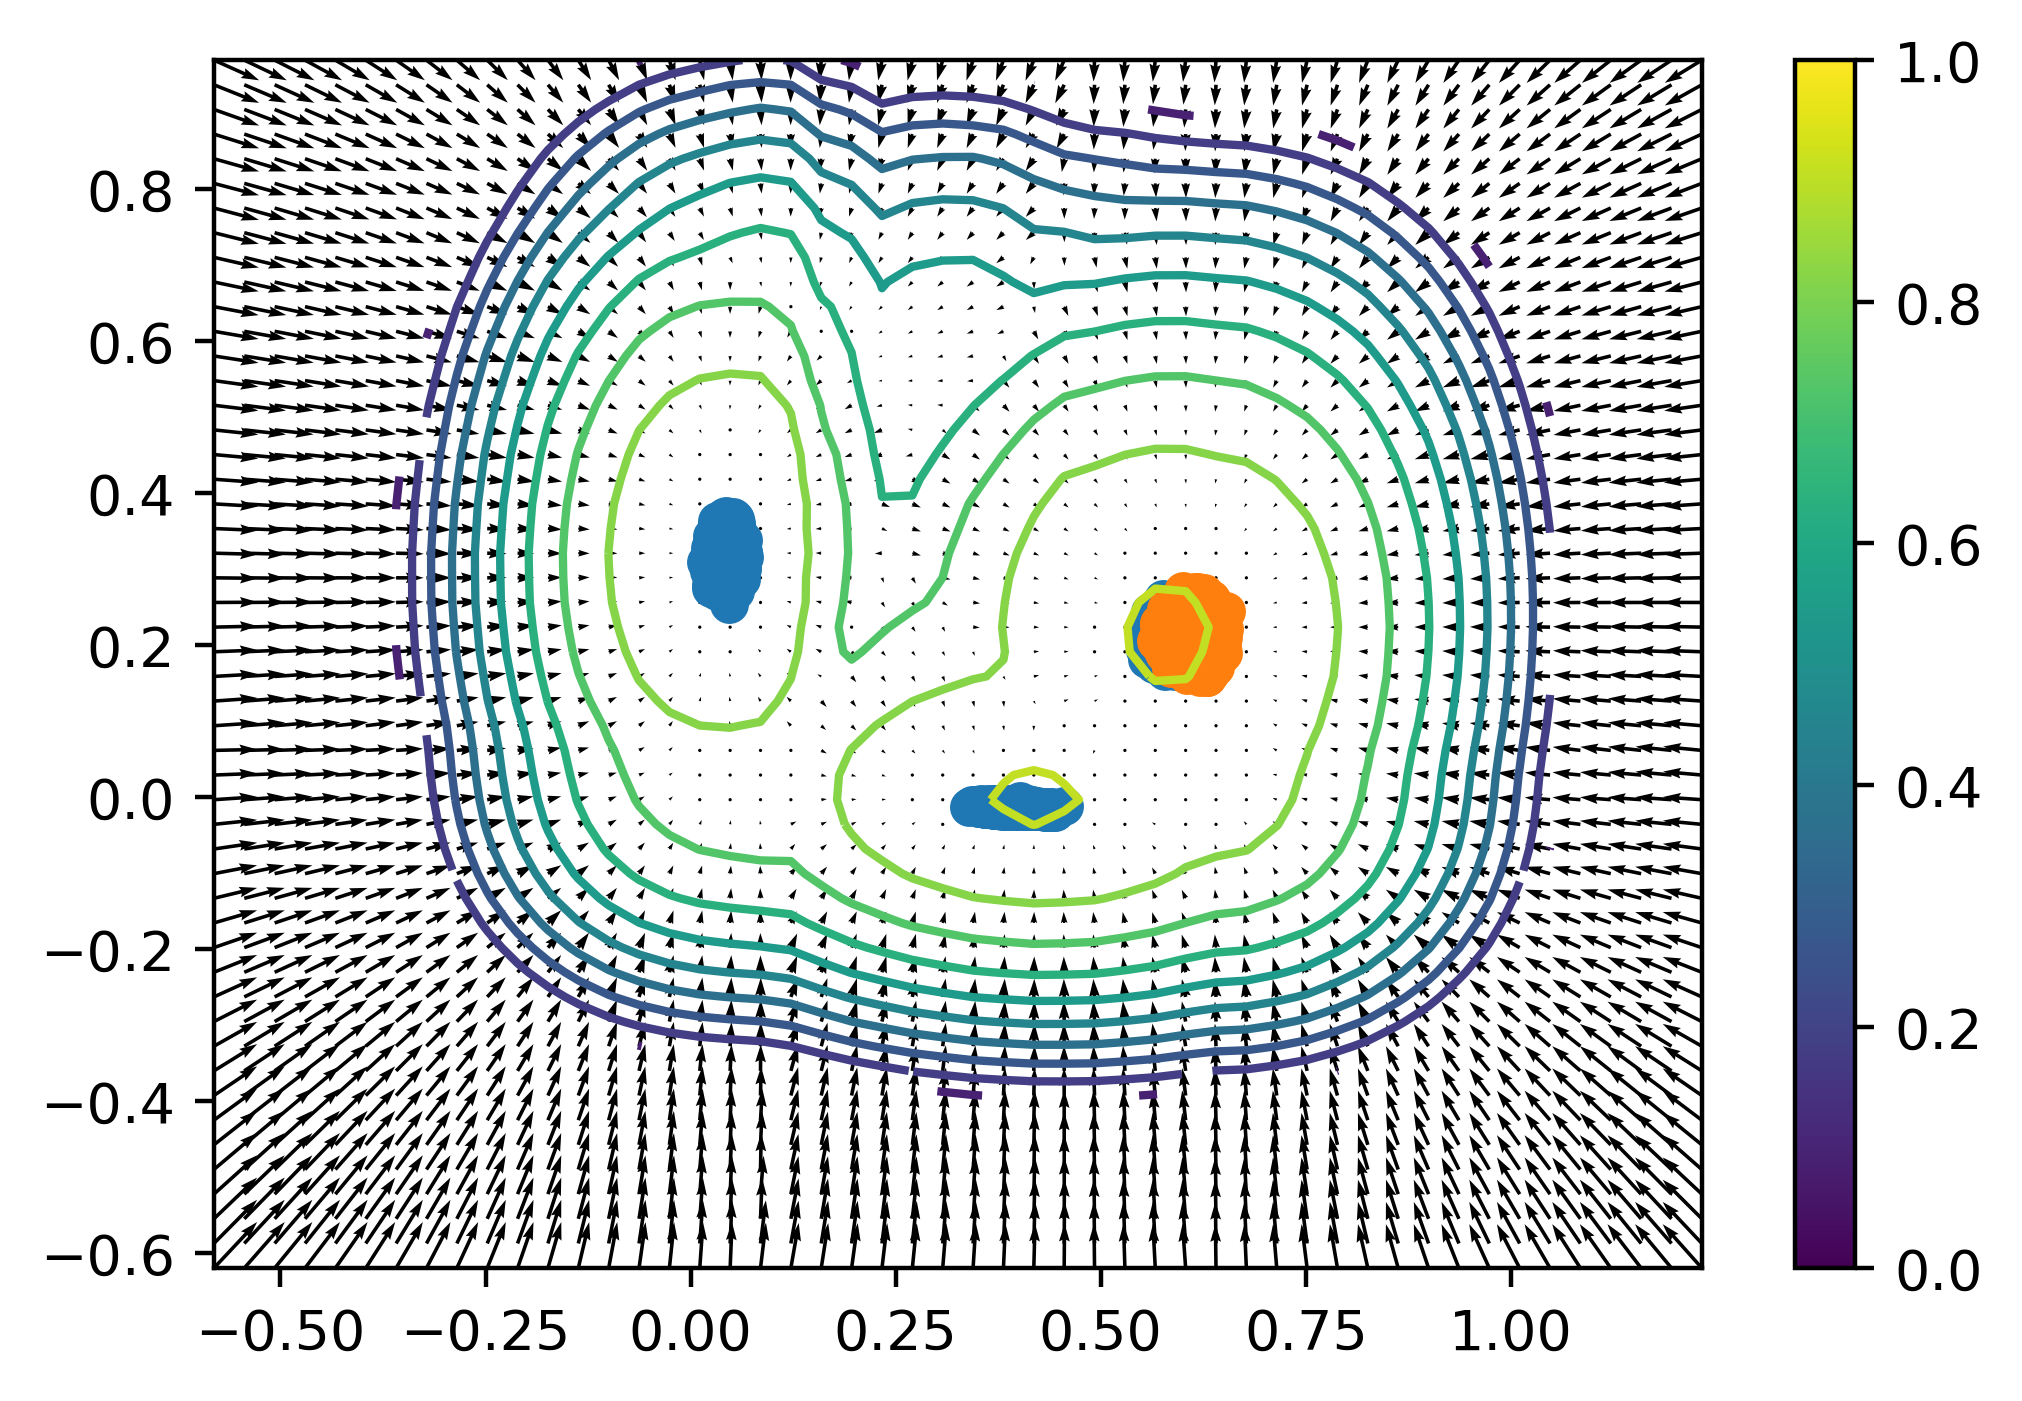

In [58]:
X, Y = np.meshgrid(w_hat_dim[0], w_hat_dim[1])

plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], torch.log(p_m.cpu()), 10)
plt.scatter(proj_data[:,0], proj_data[:,1])
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.colorbar()

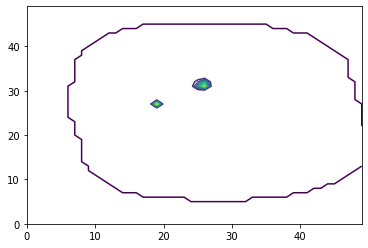

In [56]:
plt.contour(torch.log(p_m.cpu()))

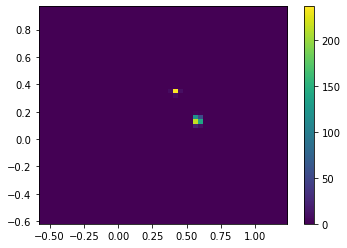

In [21]:
plt.imshow(p_m.cpu().T, extent = [xmin, xmax, ymin, ymax])
plt.colorbar()

[]

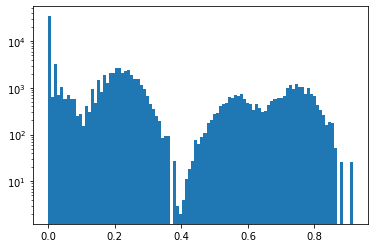

In [22]:
plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins = 100);
plt.semilogy()

In [23]:
X = myRBM.getMiniBatches(data.T, 15)
v_pos = X
h_pos_v, h_pos_m = myRBM.SampleHiddens01(X)

In [24]:

X_pc, _, h_neg_v, h_neg_m = myRBM.GetAv()
_, _, h_neg_v_, h_neg_m_ = myRBM.GetAv()
v_neg = X_pc
v_neg_ = X_pc

h_neg_v_save = h_neg_v.clone()
NegTerm_ia = h_neg_v.mm(v_neg.t())
NegTerm_ia_bad = h_neg_v.mm(v_neg.t())
VisDataAv = torch.mean(v_pos, 1)
HidDataAv = torch.mean(h_pos_m, 1)
Xc_pos = (v_pos.t() - VisDataAv).t()
Hc_pos = (h_pos_m.t() - HidDataAv).t()

Xc_neg = (v_neg.t() - VisDataAv).t()
Hc_neg = (h_neg_m.t() - HidDataAv).t()

NormPos = 1.0/mb_s
NormNeg = 1.0/num_pcd
# NormL2 = self.regL2

siτa_neg = Hc_neg.mm(Xc_neg.t())*NormNeg
si_neg = torch.sum(v_neg, 1)*NormNeg
τa_neg = torch.sum(h_neg_m, 1)*NormNeg

ΔW = Hc_pos.mm(Xc_pos.t())*NormPos - siτa_neg

ΔW_neg_test = NegTerm_ia*NormNeg - torch.outer(torch.mean(h_neg_m,1).float(), VisDataAv) - \
            torch.outer(HidDataAv, torch.mean(v_neg,1)) + torch.outer(HidDataAv, VisDataAv)

ΔW_neg_test_bad = NegTerm_ia_bad*NormNeg - torch.outer(torch.mean(h_neg_v,1).float(), VisDataAv) - \
            torch.outer(HidDataAv, torch.mean(v_neg,1)) + torch.outer(HidDataAv, VisDataAv)

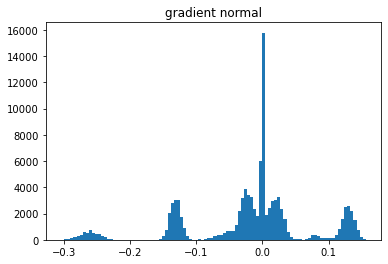

In [25]:
plt.hist(siτa_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.title("gradient normal");

In [26]:
torch.mean(h_neg_v,1)

tensor([0.0017, 1.0000, 0.9983, 0.0800, 0.9983, 0.0000, 0.0017, 0.0000, 0.9250,
        0.9983, 0.9983, 0.0017, 0.9983, 0.0733, 1.0000, 0.9950, 0.0833, 0.8867,
        0.9950, 0.0017, 0.0017, 0.0017, 0.9983, 0.7300, 0.9217, 0.0017, 1.0000,
        0.0017, 0.0017, 0.0017, 1.0000, 0.0000, 0.9817, 0.9983, 1.0000, 0.0017,
        0.1167, 0.9983, 0.9933, 0.0000, 0.0033, 0.9283, 0.0017, 0.0017, 1.0000,
        0.0000, 0.0000, 0.9983, 0.0017, 1.0000, 0.0017, 0.9983, 0.0017, 1.0000,
        0.9983, 0.0017, 1.0000, 0.0000, 0.0017, 0.9983, 0.9983, 0.0017, 0.9317,
        0.0800, 0.0017, 0.0000, 0.0083, 0.0017, 0.0000, 0.0017, 0.8583, 0.9983,
        0.0850, 0.0017, 0.0017, 0.9983, 1.0000, 0.1433, 0.0017, 1.0000, 0.0017,
        0.0017, 0.0017, 0.9983, 0.0017, 1.0000, 0.0017, 1.0000, 0.9100, 0.0000,
        0.9967, 0.8450, 0.0017, 0.0017, 1.0000, 1.0000, 0.9967, 0.9250, 0.0017,
        0.9150], device='cuda:0')

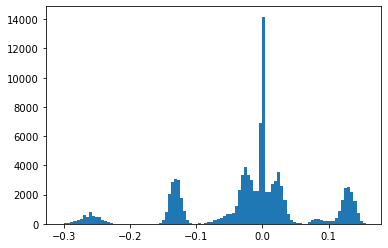

In [27]:
plt.hist((ΔW_neg_test_bad).cpu().numpy().reshape(Nv*Nh), bins = 100);

[]

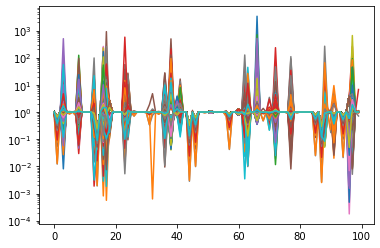

In [28]:
plt.plot(torch.abs(ΔW_neg_test_bad/ΔW_neg_test).cpu().numpy());
plt.semilogy()

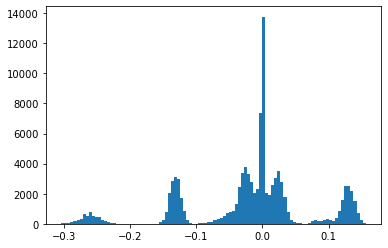

In [29]:
plt.hist(ΔW_neg_test.cpu().numpy().reshape(Nv*Nh), bins = 100);

In [30]:
xxxx = (h_neg_v.mm(v_neg.t())/600 - h_neg_m.mm(v_neg.t())/600)

In [31]:
y=torch.outer(torch.mean(h_neg_v,1).float(), VisDataAv) - torch.outer(torch.mean(h_neg_m,1).float(), VisDataAv)

In [32]:
yy=torch.mean(h_neg_v,1).float() - torch.mean(h_neg_m,1).float()

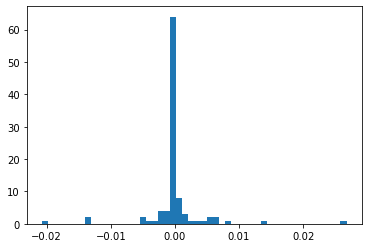

In [33]:
plt.hist(yy.reshape(100).cpu().numpy(),bins=50);

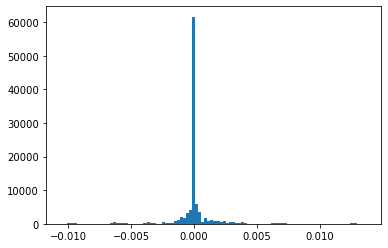

In [34]:
plt.hist(y.reshape(100000).cpu().numpy(),bins=100);

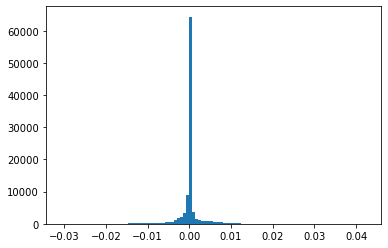

In [35]:
plt.hist(xxxx.reshape(100000).cpu().numpy(),bins=100);

In [36]:
1/600**0.5

0.040824829046386304

In [37]:
print(v_neg.shape)
print(torch.mean(h_neg_v,1).shape)
VIS = VisDataAv.repeat(600,1).T

torch.Size([1000, 600])
torch.Size([100])


In [38]:
(v_neg - VIS)

tensor([[ 0.5650,  0.5650,  0.5650,  ...,  0.5650,  0.5650,  0.5650],
        [-0.2617, -0.2617, -0.2617,  ...,  0.7383, -0.2617, -0.2617],
        [ 0.5433,  0.5433,  0.5433,  ...,  0.5433,  0.5433,  0.5433],
        ...,
        [ 0.7683,  0.7683,  0.7683,  ...,  0.7683, -0.2317,  0.7683],
        [ 0.5517,  0.5517,  0.5517,  ...,  0.5517,  0.5517,  0.5517],
        [-0.2450, -0.2450,  0.7550,  ...,  0.7550, -0.2450, -0.2450]],
       device='cuda:0')

In [39]:
Xc_neg

tensor([[ 0.5650,  0.5650,  0.5650,  ...,  0.5650,  0.5650,  0.5650],
        [-0.2617, -0.2617, -0.2617,  ...,  0.7383, -0.2617, -0.2617],
        [ 0.5433,  0.5433,  0.5433,  ...,  0.5433,  0.5433,  0.5433],
        ...,
        [ 0.7683,  0.7683,  0.7683,  ...,  0.7683, -0.2317,  0.7683],
        [ 0.5517,  0.5517,  0.5517,  ...,  0.5517,  0.5517,  0.5517],
        [-0.2450, -0.2450,  0.7550,  ...,  0.7550, -0.2450, -0.2450]],
       device='cuda:0')

In [40]:
_, _, V_d = torch.svd(data.T)

In [41]:
w_hat_dim[0]

array([-0.58113223, -0.54411368, -0.50709512, -0.47007657, -0.43305801,
       -0.39603945, -0.3590209 , -0.32200234, -0.28498379, -0.24796523,
       -0.21094668, -0.17392812, -0.13690956, -0.09989101, -0.06287245,
       -0.0258539 ,  0.01116466,  0.04818321,  0.08520177,  0.12222033,
        0.15923888,  0.19625744,  0.23327599,  0.27029455,  0.30731311,
        0.34433166,  0.38135022,  0.41836877,  0.45538733,  0.49240588,
        0.52942444,  0.566443  ,  0.60346155,  0.64048011,  0.67749866,
        0.71451722,  0.75153577,  0.78855433,  0.82557289,  0.86259144,
        0.89961   ,  0.93662855,  0.97364711,  1.01066566,  1.04768422,
        1.08470278,  1.12172133,  1.15873989,  1.19575844,  1.232777  ])

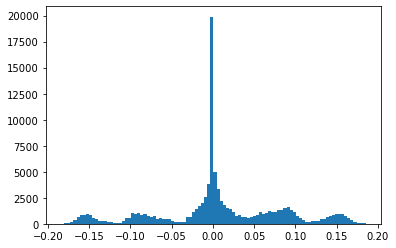

In [42]:
plt.hist(ΔW.cpu().numpy().reshape(Nv*Nh), bins = 100);

In [43]:
V_g.shape

torch.Size([1000, 100])

In [44]:
v_neg = s_i_fin
h_neg_v = tau_a_fin
h_neg_m = prod_fin.T
VisDataAv = torch.mean(v_pos, 1).float()
HidDataAv = torch.mean(h_pos_m, 1).float()    

NormPos = 1.0/mb_s
#NormNeg = 1.0/self.num_pcd


Xc_pos = (v_pos.t() - VisDataAv).t()
Hc_pos = (h_pos_m.t() - HidDataAv).t()

si_neg = v_neg
τa_neg = h_neg_v
print(h_neg_v.shape)
print(VisDataAv.shape)
print(v_neg.shape)
print(HidDataAv.shape)
print(torch.outer(HidDataAv, VisDataAv).shape)
# ΔW_neg = h_neg_m - torch.outer(h_neg_v.float(), VisDataAv) - torch.outer(HidDataAv, v_neg) + torch.outer(HidDataAv, VisDataAv)
ΔW_neg = h_neg_m - torch.outer(torch.mean(h_neg_v_,1).float(), VisDataAv) - torch.outer(HidDataAv, torch.mean(v_neg_,1)) + torch.outer(HidDataAv, VisDataAv)
ΔW = Hc_pos.mm(Xc_pos.t())*NormPos - ΔW_neg


torch.Size([100])
torch.Size([1000])
torch.Size([1000])
torch.Size([100])
torch.Size([100, 1000])


In [45]:
h_neg_v

tensor([3.1971e-01, 1.0000e+00, 9.9924e-01, 9.5372e-02, 9.9924e-01, 3.1892e-01,
        3.2042e-01, 3.1891e-01, 8.7375e-01, 9.9924e-01, 9.9924e-01, 7.5581e-04,
        9.9924e-01, 6.3228e-02, 9.9999e-01, 6.8033e-01, 7.6158e-02, 9.4523e-01,
        1.0000e+00, 7.5581e-04, 7.5581e-04, 7.5581e-04, 9.9924e-01, 7.4444e-01,
        9.3041e-01, 7.5581e-04, 7.1909e-01, 7.5581e-04, 7.5581e-04, 7.5581e-04,
        6.8033e-01, 1.0688e-05, 7.7173e-01, 9.9924e-01, 6.8039e-01, 7.5581e-04,
        9.3112e-02, 9.9924e-01, 9.9921e-01, 3.1966e-01, 6.1206e-06, 9.2142e-01,
        7.5581e-04, 3.2042e-01, 1.0000e+00, 3.1900e-01, 1.6656e-04, 9.9924e-01,
        7.5581e-04, 6.8114e-01, 3.2042e-01, 9.9917e-01, 7.5581e-04, 7.0001e-01,
        9.9924e-01, 7.5581e-04, 6.8079e-01, 4.2534e-06, 7.5581e-04, 9.9924e-01,
        1.0000e+00, 3.2042e-01, 9.9626e-01, 7.6315e-02, 3.2042e-01, 3.1912e-01,
        3.3777e-05, 7.5581e-04, 3.1983e-01, 7.5581e-04, 5.9887e-01, 9.9924e-01,
        2.2899e-02, 3.2042e-01, 7.5581e-

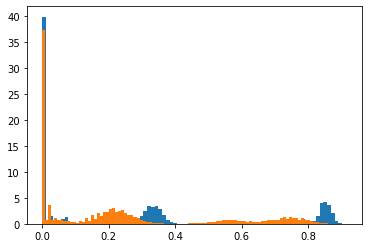

In [46]:
plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins =100,density=True);

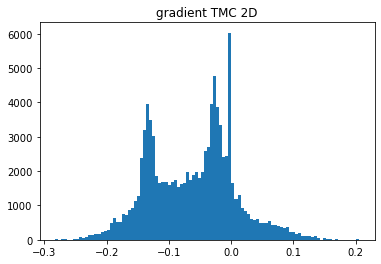

In [47]:
plt.hist(ΔW_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(prod_fin.cpu().numpy().reshape(Nv*Nh), bins =100,density=True);
plt.title("gradient TMC 2D");

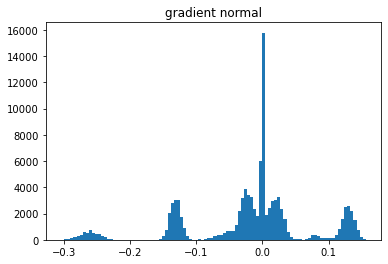

In [48]:
plt.hist(siτa_neg.cpu().numpy().reshape(Nv*Nh), bins = 100);
# plt.hist(NegTerm_ia.cpu().numpy().reshape(Nv*Nh)*NormNeg, bins = 80,density=True);
plt.title("gradient normal");

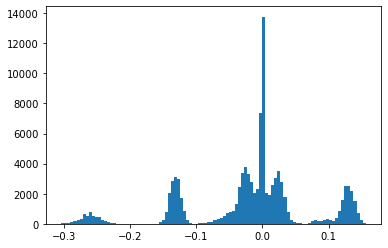

In [49]:
plt.hist(ΔW_neg_test.cpu().numpy().reshape(Nv*Nh), bins = 100);

Text(0.5, 1.0, 'negTermV')

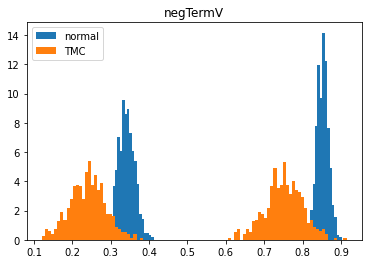

In [50]:
plt.hist(torch.mean(X_pc, 1).cpu().numpy(), density = True, bins = 100, label = "normal");
plt.hist(s_i_fin.cpu().numpy(), density = True, bins = 100, label = "TMC");
plt.legend()
plt.title("negTermV")

Text(0.5, 1.0, 'negTermV')

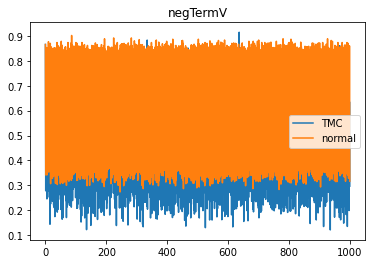

In [51]:
plt.plot(s_i_fin.cpu(), label = "TMC")
plt.plot(torch.mean(X_pc, 1).cpu().numpy(), label = "normal")

plt.legend()
plt.title("negTermV")

Text(0.5, 1.0, 'negTermH')

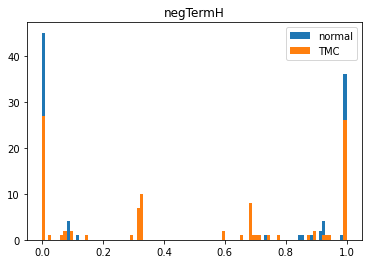

In [52]:
plt.hist(torch.mean(h_neg_v_save, 1).cpu().numpy(), label = "normal", bins =100)
plt.hist(tau_a_fin.cpu().numpy(), label = "TMC", bins =100)
plt.legend()
plt.title("negTermH")

Text(0.5, 1.0, 'negTermH')

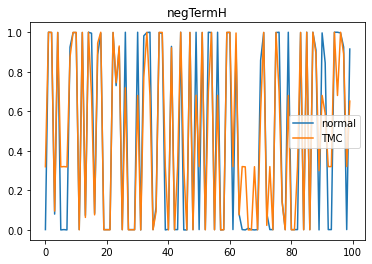

In [53]:
plt.plot(torch.mean(h_neg_v_save, 1).cpu().numpy(), label = "normal")
plt.plot(tau_a_fin.cpu().numpy(), label = "TMC")
plt.legend()
plt.title("negTermH")

In [54]:
s_i.shape

torch.Size([1000, 2500])

In [55]:
for k in range(100):
    print('-------------- : ', torch.mm(s_i[:,k].unsqueeze(1).T, V_g)[:,0])
    for i in range(10):
        proj = torch.mm(tmpv[:,k,i].unsqueeze(1).T, V_g)
        print(proj[:,0])


-------------- :  tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
-------------- :  tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
-------------- :  tensor([0.0060], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([0.04